In [4]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import portion as P
from analysis import preprocess_words, compute_interval_length

## Configuration

- Only retain segments where a complete 30-second conversation occurred.
- Exclude pair 0-3 due to the implementation errors
- Exclude pair 7 since their avatar connection was lost midway, and only the voice remained.

In [5]:
folder_path = '../Data'

conversation_start_times = [
    0,0,0,0,0,   # 0,   1,  2,  3,  4
    30,0,0,0,0,  # 5,   6,  7,  8,  9
    0,30,0,0,0,  # 10, 11, 12, 13, 14
    0,30,0,0,0,  # 15, 16, 17, 18, 19
    0,0,0,0,0,  # 20, 21, 22, 23, 24
    0,0,0,0,0,  # 25, 26, 27, 28, 29
    0,          # 30
]

conversation_end_times = [
    600,600,600,600,600,  # 0,   1,  2,  3,  4
    600,600,600,600,600,  # 5,   6,  7,  8,  9
    600,630,600,600,630,  # 10, 11, 12, 13, 14
    600,630,600,600,600,  # 15, 16, 17, 18, 19
    630,480,630,600,600,  # 20, 21, 22, 23, 24
    600,600,600,630,600,  # 25, 26, 27, 28, 29
    600,                  # 30
]

skips = [
    7
]

## Process

Function to draw words and turns

In [6]:
def drawing_words_and_turns(pid, words, turns):
    plt.figure(figsize=(50,5), dpi=300)
    plt.subplot(2,1,1)
    plt.title(f"{pid} Words")
    s = words[words.speaker=='self']['start'].reset_index(drop=True)
    d = words[words.speaker=='self']['duration'].reset_index(drop=True)
    intervals= [(s[i], d[i]) for i in range(len(s))]
    plt.broken_barh(intervals, (0,1), facecolor='blue', label='Self')

    s = words[words.speaker=='partner']['start'].reset_index(drop=True)
    d = words[words.speaker=='partner']['duration'].reset_index(drop=True)
    intervals= [(s[i], d[i]) for i in range(len(s))]
    plt.broken_barh(intervals, (0,-1), facecolor='orange', label='Partner')
    plt.yticks([0.5, -0.5], ['self', 'partner'])
    plt.xlim(-30, 660)
    
    plt.subplot(2,1,2)
    plt.title(f"{pid} Turn-Taking")
    s = turns[turns.speaker=='self']['start'].reset_index(drop=True)
    d = turns[turns.speaker=='self']['duration'].reset_index(drop=True)
    intervals= [(s[i], d[i]) for i in range(len(s))]
    plt.broken_barh(intervals, (0,1), facecolor='blue', label='Self')

    s = turns[turns.speaker=='partner']['start'].reset_index(drop=True)
    d = turns[turns.speaker=='partner']['duration'].reset_index(drop=True)
    intervals= [(s[i], d[i]) for i in range(len(s))]
    plt.broken_barh(intervals, (0,-1), facecolor='orange', label='Partner')
    plt.yticks([0.5, -0.5], ['self', 'partner'])
    plt.xlim(-30, 660)
    
    plt.tight_layout()
    plt.savefig(f'images/words_and_turns_{pid}.png')
        
    plt.show()


Function to extract turns

In [7]:
def extract_turns(words):
    words = words.sort_values(by=['start']).reset_index(drop=True)

    current_turn_speaker = words['speaker'][0]
    current_turn_start = words['start'][0]
    current_turn_end = words['end'][0]
    current_turn_text = words['text'][0]

    _turns = []

    for i in range(len(words)-1):
        # turn-extension
        if current_turn_speaker == words['speaker'][i+1]:
            current_turn_end = words['end'][i+1]
            current_turn_text += f" {words['text'][i+1]}"

        # turn-transition
        else:
            if (current_turn_end < words['end'][i+1]) :
                _turns.append(dict(speaker=current_turn_speaker, 
                                start=current_turn_start, 
                                end=current_turn_end, 
                                duration=current_turn_end-current_turn_start, 
                                text=current_turn_text))
                
                current_turn_speaker = words['speaker'][i+1]
                current_turn_start = words['start'][i+1]
                current_turn_end = words['end'][i+1]
                current_turn_text = words['text'][i+1]

        
    turns = pd.DataFrame(_turns)
    
    # compute response time
    turns['responsetime'] = np.nan
    for j in range(1, len(turns)):
        turns.loc[j, 'responsetime'] = turns.loc[j, 'start'] - turns.loc[j-1, 'end']

    return turns

Extract turns

In [10]:
turns_all = pd.DataFrame()

for i in range(4,31):

    if i in set(skips):
        continue

    for p in ['a', 'b']:
        pid = f'{i}{p}'
        
        # print(f'### {pid} processing')
        starttime = conversation_start_times[i]
        endtime = conversation_end_times[i]

        # load social connection responses
        social_connection = pd.read_table(f'{folder_path}/RawData/{pid}_video_measure.tsv')
        
        # load self-words
        words_self = pd.read_csv(f"_utterances/{pid}_vad_self.csv"); words_self['speaker']='self'; words_self['text']=''
        words_self = words_self[(words_self.start> starttime) & (words_self.end < endtime)].reset_index(drop=True)
        words_self = preprocess_words(words_self)

        # load partner-words
        words_partner = pd.read_csv(f"_utterances/{pid}_vad_partner.csv"); words_partner['speaker']='partner'; words_partner['text']=''
        words_partner = words_partner[(words_partner.start > starttime)&(words_partner.end < endtime)].reset_index(drop=True)
        words_partner = preprocess_words(words_partner)
        
        words = pd.concat([words_self, words_partner])
        turns = extract_turns(words)
        turns['pid'] = pid
        turns = turns[(turns.start >= starttime) & (turns.start < endtime)]
        
        turns_all = pd.concat([turns_all, turns]).reset_index(drop=True)


Set a boundary to remove response time outliers

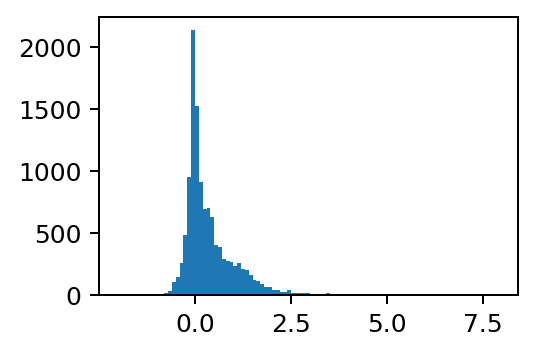

response time descrive statistics
mean : 0.37455898336259513 (sd= 0.7413410235943931)
range : [-1.849464087420584, 2.5985820541457745]


count    11961.000000
mean         0.374559
std          0.741341
min         -1.180000
25%         -0.040000
50%          0.140000
75%          0.600000
max         19.840000
Name: responsetime, dtype: float64

In [11]:
rt_mean = turns_all.responsetime.mean()
rt_std = turns_all.responsetime.std()
rt_lb = turns_all.responsetime.mean() - turns_all.responsetime.std() * 3
rt_ub = turns_all.responsetime.mean() + turns_all.responsetime.std() * 3

plt.figure(figsize=(3,2), dpi=180)
plt.hist(turns_all.responsetime, np.arange(-2, 8, 0.1))
plt.show()


print("response time descrive statistics")
print(f"mean : {rt_mean} (sd= {rt_std})")
print(f"range : [{rt_lb}, {rt_ub}]")

turns_all.responsetime.describe()

In [12]:
turns_all.to_csv("processed/turns.csv")

Main process

In [15]:
df_voices = pd.DataFrame([])
df_ratings = pd.DataFrame()
df_rt = pd.DataFrame()
bins_all = pd.DataFrame()

for i in range(4,31):

    if i in set(skips):
        continue

    for p in ['a', 'b']:
        pid = f'{i}{p}'
        
        print(f'# {pid} processing')
        starttime = conversation_start_times[i]
        endtime = conversation_end_times[i]

        # load social connection responses
        social_connection = pd.read_table(f'{folder_path}/RawData/{pid}_video_measure.tsv')
        _df_rating = pd.read_table(f'{folder_path}/RawData/{i}{p}_post_conversation.tsv')
        _df_rating['Pid'] = f'{i}{p}'
        
        # load self-words
        # words_self = load_words(f'{folder_path}/Transcription_Clova/{pid}_self_words.csv', is_self=True)
        words_self = pd.read_csv(f"_utterances/{pid}_vad_self.csv"); words_self['speaker']='self'; words_self['text']=''
        words_self = words_self[(words_self.start> starttime) & (words_self.end < endtime)].reset_index(drop=True)
        words_self = preprocess_words(words_self)

        # load partner-words
        # words_partner = load_words(f'{folder_path}/Transcription_Clova/{pid}_partner_words.csv', is_self=False)
        words_partner = pd.read_csv(f"_utterances/{pid}_vad_partner.csv"); words_partner['speaker']='partner'; words_partner['text']=''
        words_partner = words_partner[(words_partner.start > starttime)&(words_partner.end < endtime)].reset_index(drop=True)
        words_partner = preprocess_words(words_partner)
        words = pd.concat([words_self, words_partner])
        
        
        # load turns
        turns = extract_turns(words)
        turns['pid'] = pid
        turns = turns[(turns.start >= starttime) & (turns.start < endtime)]
        turns.loc[(turns.responsetime < rt_lb) | (turns.responsetime >= rt_ub), 'responsetime'] = np.nan
        # turns_all = pd.concat([turns_all, turns]).reset_index(drop=True)


        # compute quater response time mean
        turns['qrt_mean'] = np.nan
        for start, end in [(0, 150), (150, 300), (300, 450), (450, 600), (600, 750)]:
            turns.loc[(turns.start >= start) & (turns.start < end), 'qrt_mean'] = \
                turns[(turns.start >= start) & (turns.start < end)]['responsetime'].mean()

        turns['self_qrt_mean'] = np.nan  
        for start, end in [(0, 150), (150, 300), (300, 450), (450, 600), (600, 750)]:
            turns.loc[ (turns.speaker=='self') &(turns.start >= start) & (turns.start < end), 'self_qrt_mean'] = \
                turns[ (turns.speaker=='self') &(turns.start >= start) & (turns.start < end)]['responsetime'].mean()
        
        turns['partner_qrt_mean'] = np.nan  
        for start, end in [(0, 150), (150, 300), (300, 450), (450, 600), (600, 750)]:
            turns.loc[ (turns.speaker=='partner') &(turns.start >= start) & (turns.start < end), 'partner_qrt_mean'] = \
                turns[ (turns.speaker=='partner') &(turns.start >= start) & (turns.start < end)]['responsetime'].mean()
        


        # append segment data
        _bins = []  # List to store the rows of the resulting DataFrame
        start, end = int(starttime) // 30, int(endtime) // 30  # Convert start and end time to segment index

        for j in range(start, end):
            t_seg_start, t_seg_end = j * 30, (j + 1) * 30
            
            # turns for a bin
            turns_seg = turns[(turns.start >= t_seg_start) & (turns.start < t_seg_end)].copy().reset_index(drop=True)
            if len(turns_seg) > 0:
                turns_seg.loc[len(turns_seg)-1,'end'] = min(t_seg_end, turns_seg.loc[len(turns_seg)-1, 'end']) # cap

            self_turns_seg = turns_seg[turns_seg.speaker=='self'].copy().reset_index(drop=True)
            partner_turns_seg = turns_seg[turns_seg.speaker=='partner'].copy().reset_index(drop=True)
            rating_seg = social_connection[(social_connection.TimeStamp>= t_seg_start) 
                & (social_connection.TimeStamp < t_seg_end)]['SocialConnection']

            # utterance intervals for speaking interval
            self_words_seg = words_self[(words_self.start >= t_seg_start) & (words_self.start < t_seg_end)].copy().reset_index(drop=True)
            if len(self_words_seg) > 0:
                self_words_seg.loc[len(self_words_seg)-1,'end'] = min(t_seg_end, self_words_seg.loc[len(self_words_seg)-1, 'end'])
            partner_words_seg = words_partner[(words_partner.start >= t_seg_start) & (words_partner.start < t_seg_end)].copy().reset_index(drop=True)
            if len(partner_words_seg) > 0:
                partner_words_seg.loc[len(partner_words_seg)-1,'end'] = min(t_seg_end, partner_words_seg.loc[len(partner_words_seg)-1, 'end'])

            # compute word intervals (IPU, utterance)
            self_word_durations = P.Interval(*[P.closed(self_words_seg.loc[k, 'start'], self_words_seg.loc[k, 'end']) for k in range(0, len(self_turns_seg))])
            partner_word_durations = P.Interval(*[P.closed(partner_words_seg.loc[k, 'start'], partner_words_seg.loc[k, 'end']) for k in range(0, len(partner_turns_seg))])
            word_durations = self_word_durations.union(partner_word_durations)
            
            # compute turn intervals
            turn_durations = P.Interval(*[P.closed(turns_seg.loc[k, 'start'], turns_seg.loc[k, 'end']) for k in range(0, len(turns_seg))])
            self_turn_durations = P.Interval(*[P.closed(self_turns_seg.loc[k, 'start'], self_turns_seg.loc[k, 'end']) for k in range(0, len(self_turns_seg))])
            partner_turn_durations = P.Interval(*[P.closed(partner_turns_seg.loc[k, 'start'], partner_turns_seg.loc[k, 'end']) for k in range(0, len(partner_turns_seg))])
            

            _bins.append(dict(Pid=pid,
                        Session=pid[:-1],  # Assuming session is derived from pid
                        Segment=j,
                        StartTime=t_seg_start,
                        EndTime=t_seg_end,
                        Count=len(turns_seg)-1,
                        
                        # Contributions of self and others
                        SpeakingTime = compute_interval_length(word_durations),
                        SelfSpeakingTime= compute_interval_length(self_word_durations),
                        PartnerSpeakingTime= compute_interval_length(partner_word_durations),
                        SpeakingTimeRatio= compute_interval_length(self_word_durations) / (compute_interval_length(word_durations) + 1e-5),

                        # Average response times and their variations
                        VRT= turns_seg['responsetime'].mean(),
                        SelfVRT=turns_seg[turns_seg.speaker=='self']['responsetime'].mean(), 
                        PartnerVRT=turns_seg[turns_seg.speaker=='partner']['responsetime'].mean(), 
                        VRTV= np.abs(turns_seg['qrt_mean'] - turns_seg['responsetime']).mean(),
                        SelfVRTV= np.abs(turns_seg[turns_seg.speaker=='self']['self_qrt_mean'] - turns_seg[turns_seg.speaker=='self']['responsetime']).mean(),
                        PartnerVRTV= np.abs(turns_seg[turns_seg.speaker=='partner']['partner_qrt_mean'] - turns_seg[turns_seg.speaker=='partner']['responsetime']).mean(),

                        # Social connection metrics
                        SocialConnection=rating_seg.mean(),
                        SocialConnectionStd=rating_seg.std()))
        
        bins_all = pd.concat([bins_all, pd.DataFrame(_bins)]).reset_index(drop=True)

# 4a processing
# 4b processing
# 5a processing
# 5b processing
# 6a processing
# 6b processing
# 8a processing
# 8b processing
# 9a processing
# 9b processing
# 10a processing
# 10b processing
# 11a processing
# 11b processing
# 12a processing
# 12b processing
# 13a processing
# 13b processing
# 14a processing
# 14b processing
# 15a processing
# 15b processing
# 16a processing
# 16b processing
# 17a processing
# 17b processing
# 18a processing
# 18b processing
# 19a processing
# 19b processing
# 20a processing
# 20b processing
# 21a processing
# 21b processing
# 22a processing
# 22b processing
# 23a processing
# 23b processing
# 24a processing
# 24b processing
# 25a processing
# 25b processing
# 26a processing
# 26b processing
# 27a processing
# 27b processing
# 28a processing
# 28b processing
# 29a processing
# 29b processing
# 30a processing
# 30b processing


### Export

In [17]:
bins_all.to_csv("processed/voice_within.csv")
bins_all

,Pid,Session,Segment,StartTime,EndTime,Count,SpeakingTime,SelfSpeakingTime,PartnerSpeakingTime,SpeakingTimeRatio,VRT,SelfVRT,PartnerVRT,VRTV,SelfVRTV,PartnerVRTV,SocialConnection,SocialConnectionStd
0,4a,4,0,0,30,8,1.74,0.74,1.00,0.425285,0.550000,0.560000,0.540000,0.565000,0.389231,0.886154,20.79160,3.553701e-15
1,4a,4,1,30,60,14,4.62,2.46,2.16,0.532466,0.707143,0.548571,0.865714,0.670989,0.517363,0.824615,24.25687,3.553701e-15
2,4a,4,2,60,90,11,3.04,1.06,2.30,0.348683,0.360000,0.200000,0.520000,0.508974,0.353333,0.697436,30.32109,7.107402e-15
3,4a,4,3,90,120,7,1.74,1.00,1.60,0.574709,0.207500,-0.130000,0.545000,0.560962,0.450769,0.545000,21.70032,0.000000e+00
4,4a,4,4,120,150,9,1.88,0.82,1.06,0.436168,0.296000,0.216000,0.376000,0.402769,0.236308,0.534462,25.02119,3.553701e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,30b,30,15,450,480,17,5.36,2.62,2.92,0.488805,0.040000,0.115556,-0.045000,0.345511,0.210234,0.595000,39.89297,7.107402e-15
1034,30b,30,16,480,510,16,4.34,0.94,3.44,0.216589,0.454118,0.422500,0.482222,0.488421,0.435526,0.516667,38.16034,7.107402e-15
1035,30b,30,17,510,540,15,5.72,2.18,3.84,0.381118,0.397500,0.195000,0.600000,0.642895,0.315000,0.967500,37.43840,7.107402e-15
1036,30b,30,18,540,570,13,3.20,1.56,1.68,0.487498,0.611429,0.262857,0.960000,0.500000,0.175414,0.724286,37.43840,7.107402e-15


In [18]:
bins_across = bins_all.groupby(by='Pid', as_index=False).mean(numeric_only=True)
bins_across['pid'] = bins_across['Pid']
bins_across.to_csv("processed/voice_across.csv")

# Descriptive Statistics

In [12]:
turns_all[turns_all.speaker == 'self'].responsetime.describe()

count    5980.000000
mean        0.299137
std         0.686194
min        -1.180000
25%        -0.020000
50%         0.140000
75%         0.460000
max        19.840000
Name: responsetime, dtype: float64

In [20]:
turns_all[turns_all.speaker == 'partner'].responsetime.describe()

count    5981.000000
mean        0.449968
std         0.785502
min        -1.160000
25%        -0.040000
50%         0.140000
75%         0.880000
max        17.300000
Name: responsetime, dtype: float64

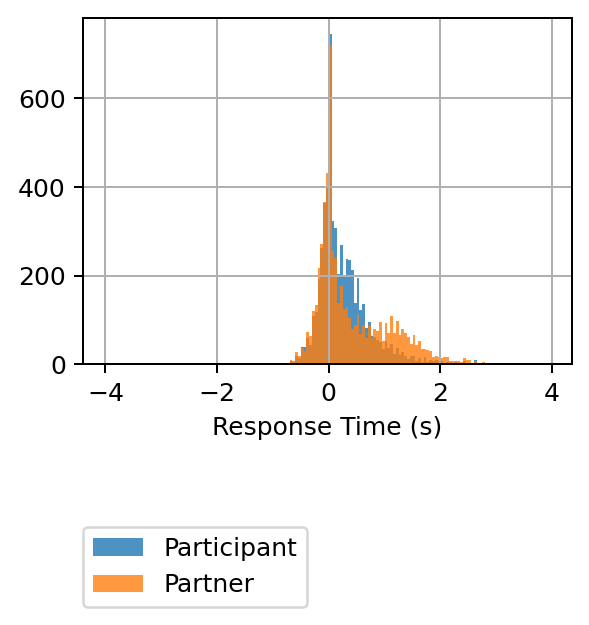

In [21]:
plt.style.use('default')
plt.figure(figsize=(3.5,2.5), dpi=180)
plt.hist(turns_all[turns_all.speaker == 'self'].responsetime, alpha=0.8, bins=np.arange(-4, 4, 0.05), label="Participant")
plt.hist(turns_all[turns_all.speaker == 'partner'].responsetime, alpha=0.8, bins=np.arange(-4, 4, 0.05), label="Partner")
plt.legend(loc=(0,-0.7))
plt.grid()
plt.xlabel("Response Time (s)")
plt.show()